<a href="https://colab.research.google.com/github/Tommy840602/GRU/blob/main/GRU_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers

In [2]:
train_df = pd.read_csv("/content/Corona_NLP_train.csv",encoding='latin1')
test_df = pd.read_csv("/content/Corona_NLP_test.csv",encoding='latin1')

In [3]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
train_df.shape

(41157, 6)

In [6]:
test_df.shape

(3798, 6)

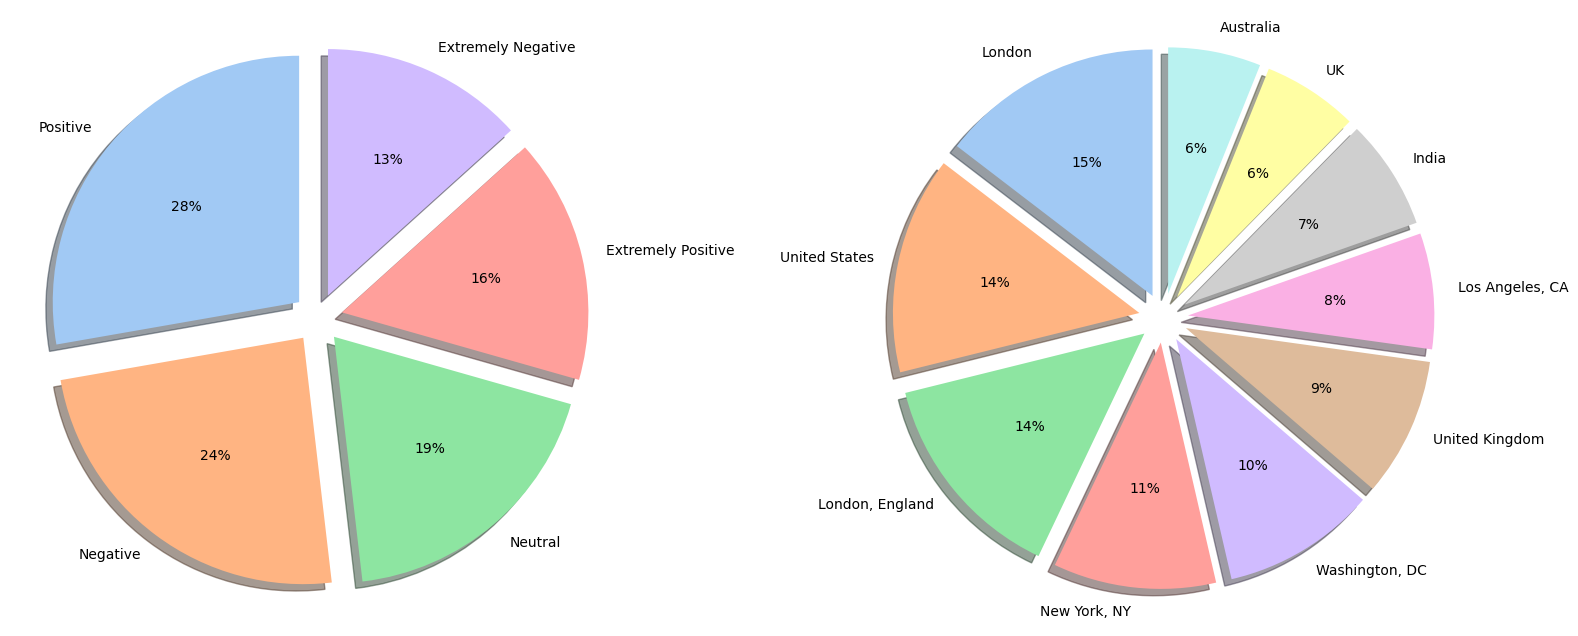

In [8]:
#EDA
def plot_pie(df, column, axes, amount=-1):
    count_classes = df[column].value_counts()
    if (amount != -1):
        count_classes = count_classes[:amount]
    n_classes = len(count_classes)
    explode = (0.1,) * n_classes # explode for 0.1 each slice
    colors = sns.color_palette('pastel') # pastel colors
    axes.pie(count_classes,
             labels=count_classes.index,
             explode=explode,
             colors=colors,
             autopct='%.0f%%',
             shadow=True,
             startangle=90)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
plot_pie(train_df, "Sentiment", axes[0])
plot_pie(train_df, "Location", axes[1], 10) # only first 10 locations
plt.show()

In [ ]:
#Prepare data

In [9]:
y = train_df["Sentiment"].map({"Negative":0,
                               "Positive": 1,
                               "Neutral": 2,
                               "Extremely Positive": 3,
                               "Extremely Negative": 4
                               })

y_test = test_df["Sentiment"].map({"Negative":0,
                                   "Positive": 1,
                                   "Neutral": 2,
                                   "Extremely Positive": 3,
                                   "Extremely Negative": 4
                                                })

In [10]:
n_classes = train_df["Sentiment"].nunique()
n_classes

5

In [12]:
#TextVectorization
X = train_df['OriginalTweet'].to_numpy()
X_test = test_df['OriginalTweet'].to_numpy()

In [13]:
text_vectorizer = TextVectorization(max_tokens=10000, standardize="lower_and_strip_punctuation", output_sequence_length=15)

In [14]:
text_vectorizer.adapt(X)

In [15]:
text_vectorizer(["Computer vision and deep learning"])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[4031, 8344,    4, 1661, 2049,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [16]:
words = text_vectorizer.get_vocabulary()
words[:10]

['', '[UNK]', 'the', 'to', 'and', 'of', 'a', 'in', 'coronavirus', 'covid19']

In [17]:
# Embedding
embedding = Embedding(input_dim=10000, output_dim=128, input_length=15, name = 'embeding_1')
embedding

In [18]:
sample_embed = embedding(text_vectorizer(["Computer vision and deep learning"]))
sample_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-4.1856565e-02,  3.8683858e-02,  4.8299942e-02, ...,
          1.8017773e-02, -1.1756204e-02, -4.6806276e-02],
        [-8.9693815e-05,  1.7829407e-02,  4.8140500e-02, ...,
         -1.8758107e-02,  4.9962189e-02,  2.3003366e-02],
        [ 2.4620164e-02,  4.1467700e-02,  5.4156780e-04, ...,
          4.1604947e-02,  2.9613923e-02,  4.5908760e-02],
        ...,
        [-2.7215922e-02, -3.8140096e-02,  2.1501373e-02, ...,
          1.7270241e-02, -1.9161498e-02,  2.7428046e-03],
        [-2.7215922e-02, -3.8140096e-02,  2.1501373e-02, ...,
          1.7270241e-02, -1.9161498e-02,  2.7428046e-03],
        [-2.7215922e-02, -3.8140096e-02,  2.1501373e-02, ...,
          1.7270241e-02, -1.9161498e-02,  2.7428046e-03]]], dtype=float32)>

In [19]:
#Training models
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                y_pred,
                                                                                average="weighted")
  model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
  return model_results

In [20]:
def plot_NN_history(model_history, suptitle):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    fig.suptitle(suptitle, fontsize=18)

    axes[0].plot(model_history.history['accuracy'],
                 label='train accuracy',
                 color='g',
                 axes=axes[0])
    axes[0].plot(model_history.history['val_accuracy'],
                 label='val accuracy',
                 color='r',
                 axes=axes[0])
    axes[0].set_title("Model Accuracy", fontsize=16)
    axes[0].legend(loc='upper left')

    axes[1].plot(model_history.history['loss'],
                 label='train loss',
                 color='g',
                 axes=axes[1])
    axes[1].plot(model_history.history['val_loss'],
                 label='val loss',
                 color='r',
                 axes=axes[1])
    axes[1].set_title("Model Loss", fontsize=16)
    axes[1].legend(loc='upper left')

    plt.show()

In [21]:
def run_model(inputs, outputs, name, epochs, NN_name, suptitle):
    # create model
    model = tf.keras.Model(inputs, outputs, name=name)
    # compile model
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
    # check model
    model.summary()
    print()
    # train model
    print("...training model...")
    model_history = model.fit(X,
                              y,
                              epochs=epochs,
                              validation_data=(X_test, y_test),
                              verbose=True)
    print()
    # check on test data
    print("...evaluating model...")
    model.evaluate(X_test, y_test)
    print()

    # check shape
    print("y_test.shape = ", y_test.shape)
    print()

    # get the probabilities
    y_prob = model.predict(X_test)
    # get the classes
    y_hat = y_prob.argmax(axis=-1)
    # see the test labels
    print("y_test =\n", y_test)
    print()
    # check results
    res = calculate_results(y_test, y_hat)
    res = pd.DataFrame([res])
    res.insert(0, "model", NN_name)
    # visualize NN history
    plot_NN_history(model_history, suptitle)
    return model, res

In [22]:
#GRU
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax')(x)

Model: "model_1_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 1317573 (5.03 MB)
Trainable params: 1317573 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

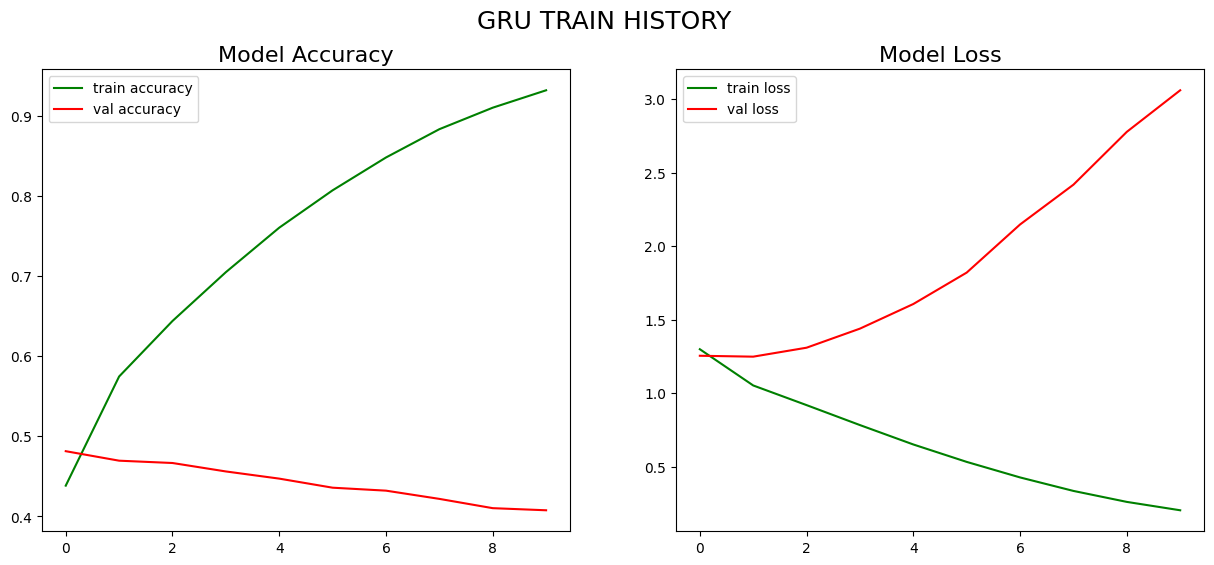

,model,accuracy,precision,recall,f1
0,GRU,40.758294,0.409939,0.407583,0.407244


In [23]:
model_1, res1 = run_model(inputs, outputs, "model_1_GRU", 10, "GRU", "GRU TRAIN HISTORY")
res1

In [24]:
#Bidirectional GRU
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax')(x)

Model: "model_3_Bidirectional_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               74496     
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 1355141 (5.17 MB)
Trainable

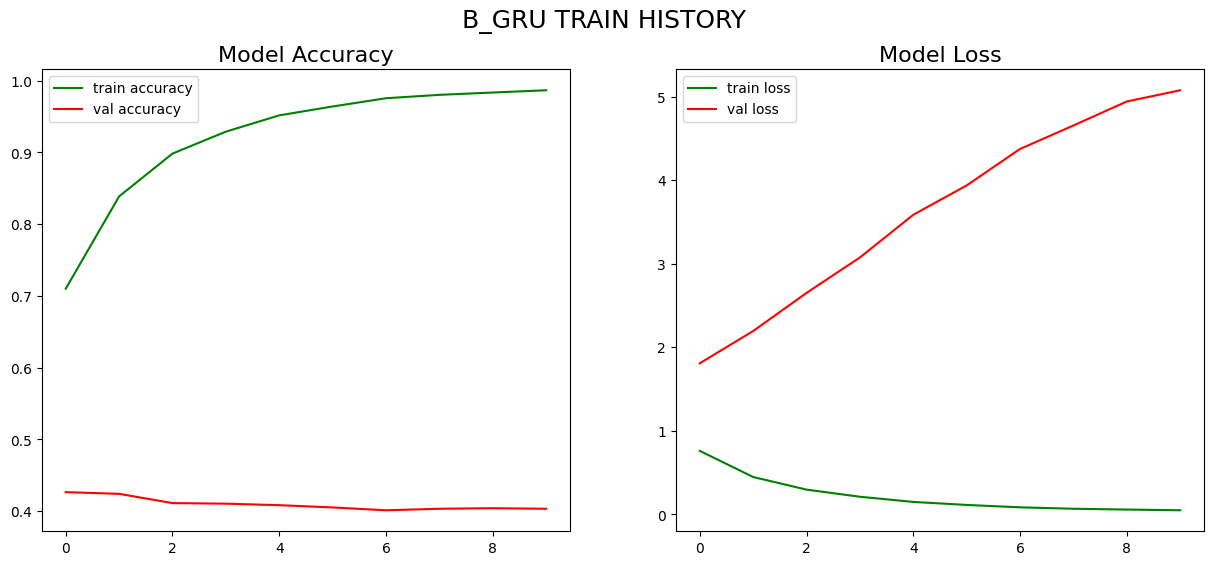

,model,accuracy,precision,recall,f1
0,B_GRU,40.337019,0.403623,0.40337,0.402727


In [25]:
model_2, res2 = run_model(inputs, outputs, "model_3_Bidirectional_GRU", 10, "B_GRU", "B_GRU TRAIN HISTORY")
res2

In [26]:
#Compare models
results = [res1, res2,]
results = pd.concat(results, ignore_index=True)
results.index = results['model']
results = results.drop(columns=['model'])

In [27]:
def plot_results(results, ax1, ax2, ax3, ax4):
    """VISUALIZE RESULTS"""
    # color = ['green', 'cyan', 'blue', 'magenta']
    color1 = plt.cm.spring(np.linspace(0, 1, len(results)))
    color2 = plt.cm.viridis(np.linspace(0, 1, len(results)))
    color3 = plt.cm.winter(np.linspace(0, 1, len(results)))
    color4 = plt.cm.cool(np.linspace(0, 1, len(results)))

    ax1 = results['accuracy'].plot.bar(ax=ax1, color=color1, legend=False)
    ax1.set_title("Accuracy", fontsize=16)

    ax2 = results['precision'].plot.bar(ax=ax2, color=color2, legend=False)
    ax2.set_title("Precision", fontsize=16)

    ax3 = results['recall'].plot.bar(ax=ax3, color=color3, legend=False)
    ax3.set_title("Recall", fontsize=16)

    ax4 = results['f1'].plot.bar(ax=ax4, color=color4, legend=False)
    ax4.set_title("F1", fontsize=16)

    print()

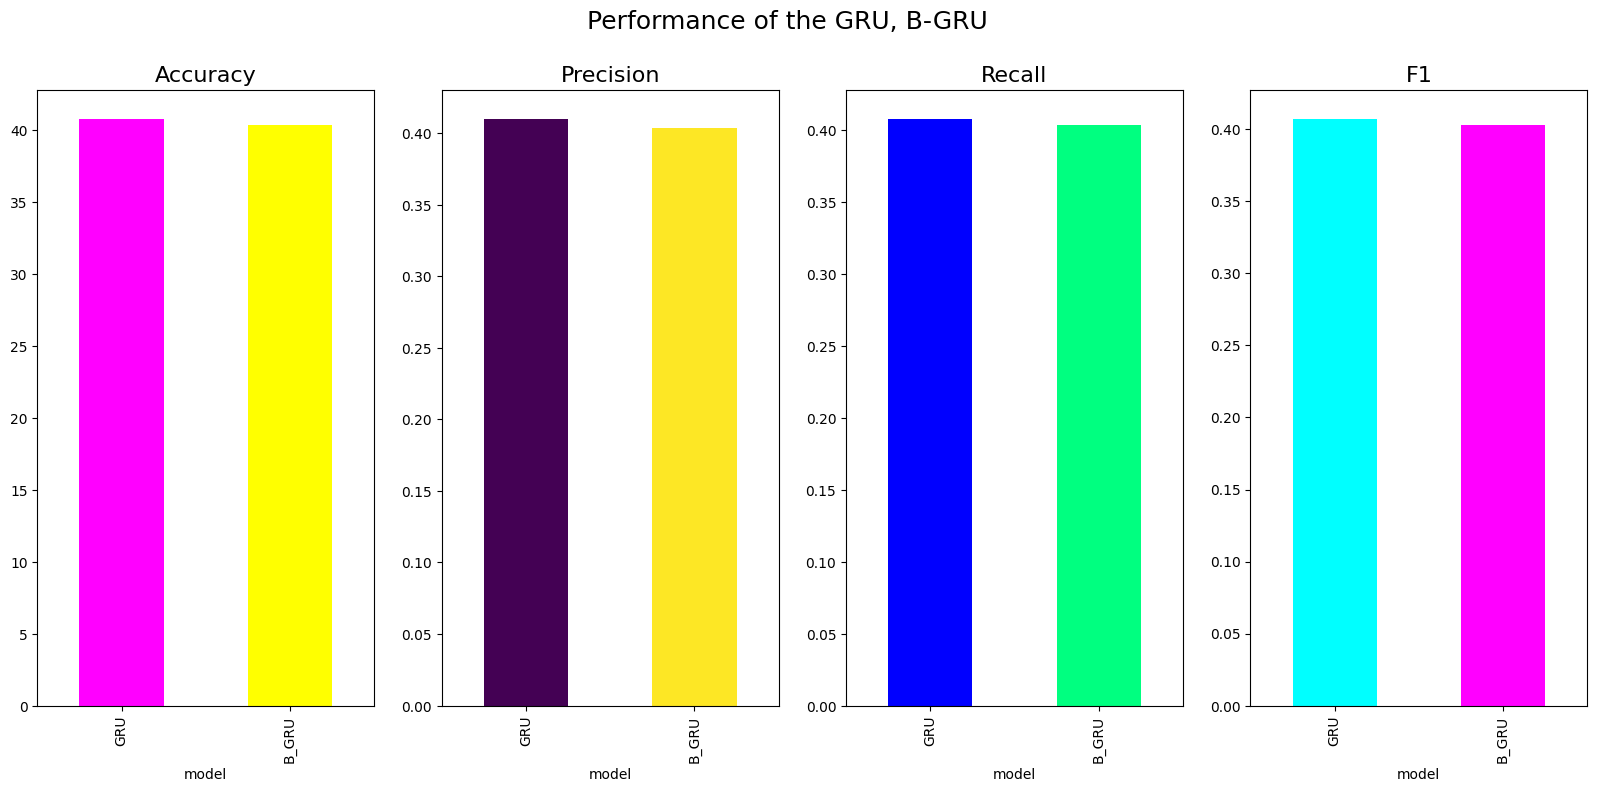

In [29]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
plt.suptitle("Performance of the GRU, B-GRU", fontsize=18)
plot_results(results, ax1, ax2, ax3, ax4)
plt.show()